# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT THÀNH PHỐ HỒ CHÍ MINH
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY ĐỂ DỰ ĐOÁN GIÁ NÔNG SẢN

Sinh viên 1: Huỳnh Hạo Nhị - 20133006

Sinh viên 2: Võ Hoài Thương - 20233012

# Thư viện

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

# Dữ liệu

## Giá lúa nội địa

Dữ liệu giá lúa được thu thập của tỉnh An Giang, từ website của Viện Chính sách và Chiến lược Phát triển Nông nghiệp Nông thôn từ năm 2007 đến nay.
*   date*: ngày
*   price: giá lúa


In [ ]:
df_rice = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/gia_lua.csv', encoding='ISO-8859-1')
df_rice.tail()

,date,price
6274,5/11/2024,16000
6275,5/12/2024,16000
6276,5/13/2024,16000
6277,5/14/2024,16000
6278,5/15/2024,16000


In [ ]:
df_rice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6279 entries, 0 to 6278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    6279 non-null   object
 1   price   6279 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 98.2+ KB


In [ ]:
df_rice['date'] = pd.to_datetime(df_rice['date'])
df_rice.set_index('date', inplace=True)

### Điền dữ liệu ngày còn thiếu

In [ ]:
idx = pd.date_range(df_rice.index.min(), df_rice.index.max())
df_rice = df_rice.reindex(idx)
df_rice.fillna(method='ffill', inplace=True)
df_rice.tail()

,price
2024-05-11,16000
2024-05-12,16000
2024-05-13,16000
2024-05-14,16000
2024-05-15,16000


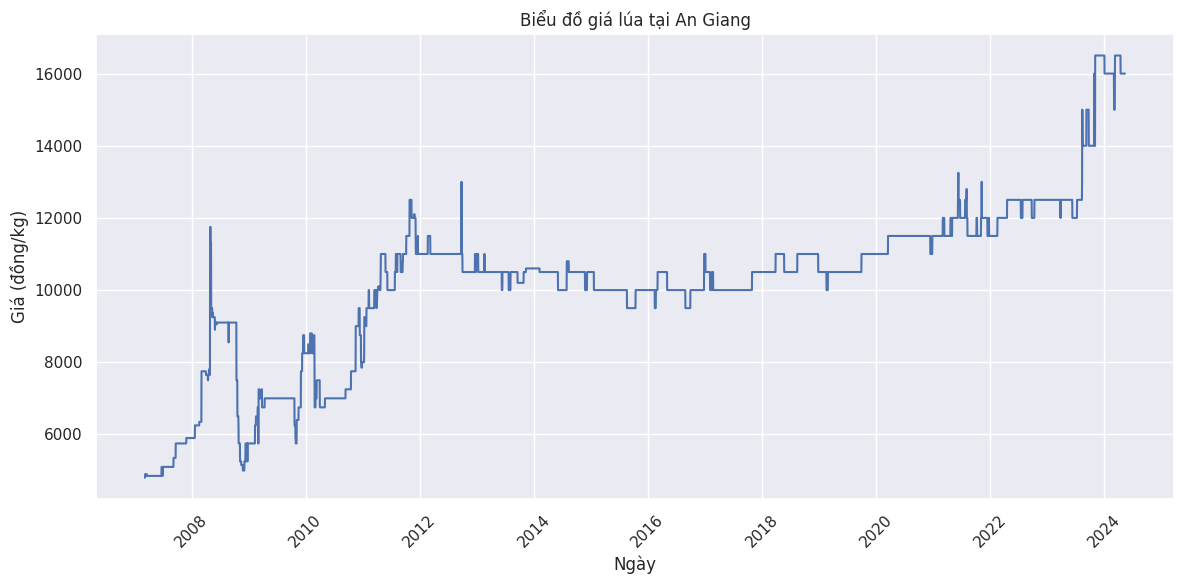

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_rice, x=df_rice.index, y='price')
plt.title('Biểu đồ giá lúa tại An Giang')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Giá lúa xuất khẩu

Dữ liệu về giá trị xuất lúa được thu thập từ website của Viện Chính sách và Chiến lược Phát triển Nông nghiệp Nông thôn.
*   date*: ngày
*   volume: Khối lượng xuất khẩu (tấn)
*   value: Kim ngạch xuất khẩu (USD)
*   value/volume: Giá trị xuất khẩu (USD/tấn)



In [ ]:
df_rice_export = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Lua/xuat_khau_lua.csv', encoding='ISO-8859-1')
df_rice_export.head()

,date,volume,value,value/volume
0,11/1/2023,600481,400345332,666.707743
1,10/1/2023,635102,406762427,640.467873
2,9/1/2023,605410,377783375,624.012446
3,8/1/2023,921443,546405796,592.989253
4,7/1/2023,660738,362660136,548.871317


### Fill dữ liệu ngày bị thiếu

In [ ]:
df_rice_export['date'] = pd.to_datetime(df_rice_export['date'])
df_rice_export.set_index('date', inplace=True)

In [ ]:
idx = pd.date_range(df_rice_export.index.min(), df_rice_export.index.max())
df_gasoline = df_rice_export.reindex(idx)
df_gasoline.fillna(method='ffill', inplace=True)

### Merge dữ liệu xuất khẩu với giá lúa

In [ ]:
start_date = df_rice_export.index.min()
df_rice_filtered = df_rice.loc[start_date:]

df_merged_rice_export = pd.merge(df_rice_filtered, df_gasoline[['value/volume']], left_index=True, right_index=True, how='left')
df_merged_rice_export['value/volume'] = df_merged_rice_export['value/volume'].ffill()

print(df_merged_rice_export.tail())

            price  value/volume
2024-05-11  16000    666.707743
2024-05-12  16000    666.707743
2024-05-13  16000    666.707743
2024-05-14  16000    666.707743
2024-05-15  16000    666.707743


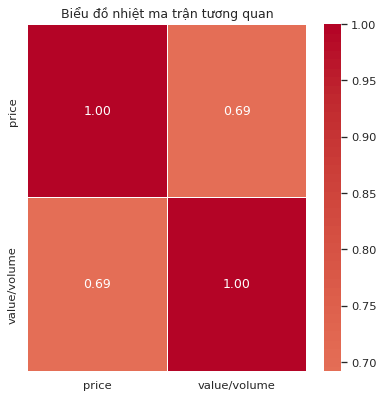

In [ ]:
correlation_matrix = df_merged_rice_export.corr()

plt.figure(figsize=(6, 6), dpi=75)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm', center=0)
plt.title('Biểu đồ nhiệt ma trận tương quan')
plt.show()

In [ ]:
# df_merged_rice_export.to_csv('gia_lua_xuat_khau.csv', index=True)

### Làm mịn dữ liệu

In [ ]:
df_merged_rice_export = df_merged_rice_export.rolling(window=30, min_periods=1).mean()

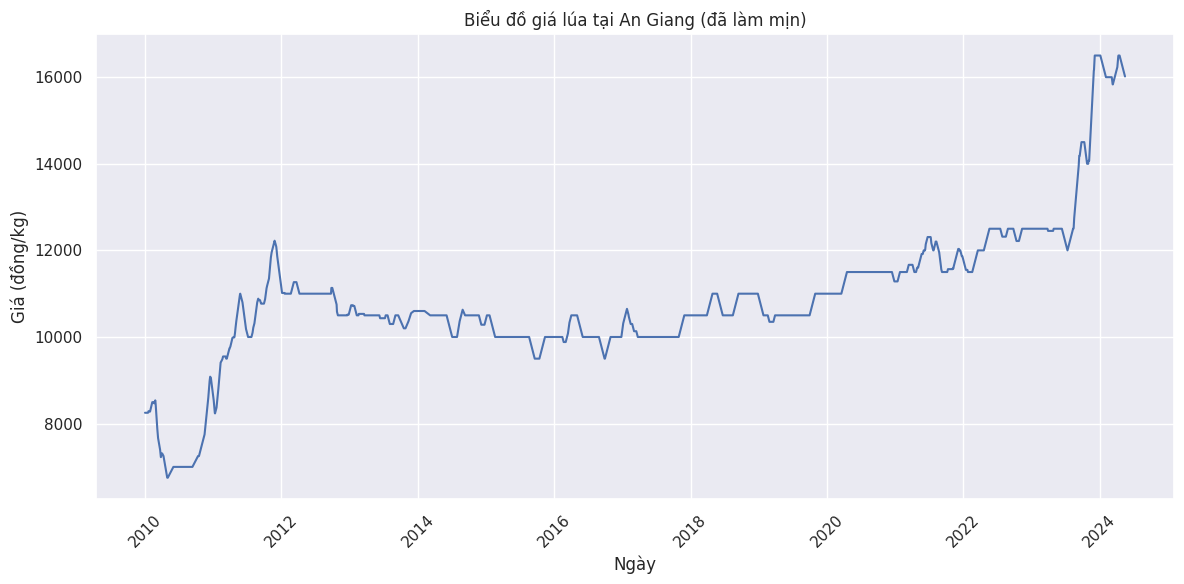

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_merged_rice_export, x=df_merged_rice_export.index, y='price')
plt.title('Biểu đồ giá lúa tại An Giang (đã làm mịn)')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mô hình BiLSTM dự đoán

Mạng Bidirectional Long Short-Term Memory (BiLSTM) là biến thể từ mạng LSTM, nó là sự kết hợp của hai lớp LSTM chạy song song ngược hướng trong cùng một chuỗi dữ liệu thời gian, một lớp LSTM chạy xuôi từ đầu đến cuối chuỗi dữ liệu và một lớp LSTM chạy ngược từ cuối về đầu chuỗi dữ liệu. Bởi vì mô hình BiLSTM xử lý thông tin cả hai hướng của chuỗi dữ liệu nên nó có thể hiểu được ngữ cảnh từ hai hướng, giúp tăng khả năng phân tích, xử lý.

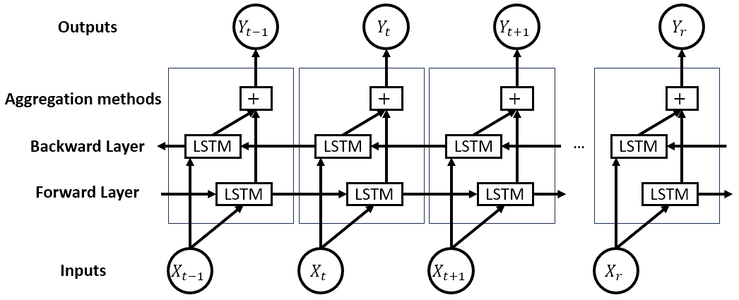

## Giá cà phê kết hợp giá xăng

### Xây dựng mô hình

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# Preprocess data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler_price.fit_transform(df_merged_rice_export[['price']])

scaler_export = MinMaxScaler(feature_range=(0, 1))
scaled_export = scaler_export.fit_transform(df_merged_rice_export[['value/volume']])

scaled_data = np.concatenate((scaled_price, scaled_export), axis=1)

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
X.shape, y.shape

((5219, 30, 2), (5219,))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (4175, 30, 2) (4175,)
Kích thước tập kiểm tra: (1044, 30, 2) (1044,)


In [ ]:
model = Sequential()
# model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(seq_length, 2)))
model.add(Bidirectional(LSTM(units=128), input_shape=(seq_length, 2)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='tanh'))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
21/66 [========>.....................] - ETA: 7s - loss: 0.0286

KeyboardInterrupt: 

### Dự đoán trên tập train

In [ ]:
train_predictions = model.predict(X_train)

In [ ]:
train_predictions = scaler_price.inverse_transform(train_predictions)
y_train = scaler_price.inverse_transform(y_train.reshape(-1, 1))

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

In [ ]:
dates = df_merged_rice_export.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá lúa trên tập huấn luyện (mô hình LSTM, dữ liệu giá lúa và giá xuất khẩu)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Dự đoán trên tập test

In [ ]:
test_predictions = model.predict(X_test)

In [ ]:
test_predictions = scaler_price.inverse_transform(test_predictions)
y_test = scaler_price.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {test_mape:.2f}%')

In [ ]:
dates = df_merged_rice_export.index.tolist()
test_dates = dates[-len(y_test):]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=test_dates, y=test_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá lúa trên tập kiểm tra (mô hình LSTM, dữ liệu giá lúa và giá xuất khẩu)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

### Lưu mô hình

In [ ]:
# model.save('BiLSTM_gia_lua_xuat_khau.h5')